# PCA 코드입니다.
* `Cell 7`의 `n_component`가 주성분을 얼마나 남길 건지 결정합니다.

In [1]:
# ============================================================
# 01_preprocessing_colored_mnist.ipynb
#
# Preprocessing pipeline for Colored MNIST:
#   1) Load MNIST
#   2) Deskew digits (no OpenCV; pure numpy + PIL)
#   3) Colorize digits (random FG/BG colors)
#   4) Add font-based digits (from TTF/OTF files)
#   5) Geometric data augmentation to reach TARGET_TOTAL samples
#   6) Train/Val/Test split
#   7) Standardize flattened features
#
# Output:
#   data/processed/colored_mnist/colored_mnist.npz
# ============================================================

import os  # filesystem paths
import random  # python-level RNG
import numpy as np  # numerical operations

import matplotlib.pyplot as plt  # visualization
import seaborn as sns  # nicer plotting style

from sklearn.preprocessing import StandardScaler  # feature scaling
from sklearn.model_selection import train_test_split  # split train/val/test

from PIL import Image, ImageDraw, ImageFont  # font rendering & affine transform

# Reproducibility
SEED = 42  # global random seed
np.random.seed(SEED)  # numpy seed
random.seed(SEED)  # python random seed

# Matplotlib style (English only to avoid font issues)
plt.rcParams["font.family"] = "DejaVu Sans"  # default font
plt.rcParams["axes.unicode_minus"] = False  # minus sign display
sns.set(style="whitegrid")  # seaborn style

print("[OK] Libraries imported and global configuration set.")
print(os.getcwd())

[OK] Libraries imported and global configuration set.
c:\src\colored-mnist-classification\notebooks


In [2]:
# ------------------------------------------------------------
# [Cell 2] Resolve repo paths and load MNIST npz file
#   - Expecting: data/raw/mnist/mnist_train.npz
#   - Keys: 'train_images' (N,28,28), 'train_labels' (N,)
# ------------------------------------------------------------

cwd = os.getcwd()  # current working directory

# If we are inside "notebooks", move one level up to repo root
if os.path.basename(cwd) == "notebooks":
    BASE_DIR = os.path.dirname(cwd)  # repo root
else:
    BASE_DIR = cwd  # already at repo root


RAW_MNIST_PATH = os.path.join(BASE_DIR, "data", "raw", "mnist", "mnist_train.npz")  # MNIST npz path
FONTS_DIR = os.path.join(BASE_DIR, "data""raw", "fonts")  # directory for TTF/OTF fonts
OUT_DIR = os.path.join(BASE_DIR, "data", "processed")  # output directory for processed data
os.makedirs(OUT_DIR, exist_ok=True)  # create output directory if not exists

OUT_NPZ = os.path.join(OUT_DIR, "deskewed_pca_mnist.npz")  # final npz file path

print(f"[INFO] BASE_DIR       : {BASE_DIR}")
print(f"[INFO] RAW_MNIST_PATH : {RAW_MNIST_PATH}")
print(f"[INFO] FONTS_DIR      : {FONTS_DIR}")
print(f"[INFO] OUT_NPZ        : {OUT_NPZ}")

if not os.path.exists(RAW_MNIST_PATH):  # check if MNIST npz exists
    raise FileNotFoundError(
        f"[ERROR] MNIST npz not found at {RAW_MNIST_PATH}.\n"
        f"Please place 'mnist_train.npz' under data/raw/mnist/."
    )

mnist = np.load(RAW_MNIST_PATH)  # load npz file
print("[INFO] mnist_train.npz keys:", list(mnist.keys()))

X_gray_all = mnist["train_images"].astype(np.float32)  # shape (N, 28, 28), grayscale 0~255
y_digit_all = mnist["train_labels"].astype(np.int64)   # shape (N,), digit labels 0~9

print("[OK] Loaded MNIST:")
print("  X_gray_all :", X_gray_all.shape)
print("  y_digit_all:", y_digit_all.shape)

[INFO] BASE_DIR       : c:\src\colored-mnist-classification
[INFO] RAW_MNIST_PATH : c:\src\colored-mnist-classification\data\raw\mnist\mnist_train.npz
[INFO] FONTS_DIR      : c:\src\colored-mnist-classification\dataraw\fonts
[INFO] OUT_NPZ        : c:\src\colored-mnist-classification\data\processed\deskewed_pca_mnist.npz
[INFO] mnist_train.npz keys: ['train_images', 'train_labels']
[OK] Loaded MNIST:
  X_gray_all : (60000, 28, 28)
  y_digit_all: (60000,)


[DEBUG] X_gray_all dtype/shape: float32 (60000, 28, 28)
[DEBUG] one sample type/shape: <class 'numpy.ndarray'> (28, 28)


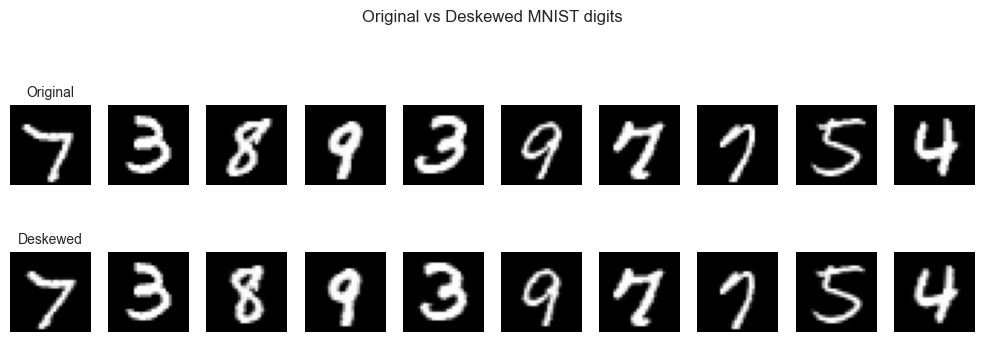

In [3]:
# ------------------------------------------------------------
# [Cell 4] Deskew function using pure numpy + PIL
#   - Moments (m00, m10, m01, mu11, mu02) computed with numpy
#   - Horizontal shear applied using PIL.Image.transform
# ------------------------------------------------------------

def compute_moments(image_2d: np.ndarray, eps: float = 1e-4):

    img = np.asarray(image_2d).astype(np.float32)  # ensure float32 numpy array
    h, w = img.shape  # image height and width

    # If image is almost empty, return zeros
    m00 = img.sum()  # total intensity
    if m00 < eps:
        return m00, 0.0, 0.0

    # Build coordinate grids
    y, x = np.mgrid[0:h, 0:w]  # y: rows, x: columns

    # Raw first-order moments
    m10 = (x * img).sum()
    m01 = (y * img).sum()

    # Centroid coordinates
    x_bar = m10 / m00
    y_bar = m01 / m00

    # Central moments
    x_shifted = x - x_bar
    y_shifted = y - y_bar

    mu11 = (x_shifted * y_shifted * img).sum()   # mixed central moment
    mu02 = (y_shifted ** 2 * img).sum()          # vertical variance moment

    return m00, mu11, mu02


def deskew(image_2d: np.ndarray, eps: float = 1e-4) -> np.ndarray:
    img = np.asarray(image_2d).astype(np.float32)  # ensure float32
    if img.ndim != 2:  # safety check for dimensionality
        raise ValueError(f"deskew() expects 2D image, got shape {img.shape}")

    # Normalize to [0,255] for moment computation if needed
    if img.max() <= 1.0 + 1e-6:
        img_m = img * 255.0  # scale up for stable moments
    else:
        img_m = img.copy()

    # Compute basic moments
    m00, mu11, mu02 = compute_moments(img_m, eps=eps)

    # If image is empty or has almost no vertical variance, skip deskew
    if m00 < eps or abs(mu02) < eps:
        return img

    # Skew factor based on central moments
    skew = mu11 / mu02  # same definition as in classic MNIST deskew

    # Build shear transform matrix for PIL
    # We want: x' = x + skew*(y - h/2), y' = y
    # PIL's affine uses: x_in = a*x + b*y + c, y_in = d*x + e*y + f
    # So we set a=1, b=skew, c=-skew*h/2, d=0, e=1, f=0
    h, w = img.shape  # height and width
    a = 1.0
    b = skew
    c = -skew * (h / 2.0)
    d = 0.0
    e = 1.0
    f = 0.0

    pil_img = Image.fromarray(img_m.astype(np.uint8))  # convert to PIL image
    deskewed_pil = pil_img.transform(
        size=(w, h),  # output size
        method=Image.AFFINE,  # affine transform
        data=(a, b, c, d, e, f),  # affine parameters
        resample=Image.BICUBIC,  # interpolation method
        fillcolor=0  # fill empty pixels with black
    )

    # Convert back to float32 and re-normalize to original range [0,1] or [0,255]
    deskewed = np.array(deskewed_pil).astype(np.float32)
    if img.max() <= 1.0 + 1e-6:
        deskewed = deskewed / 255.0  # back to [0,1]
    return deskewed


# Quick EDA: visualize Original vs Deskewed digits
n_samples_to_show = 10  # number of digits to visualize
idxs = np.random.choice(len(X_gray_all), n_samples_to_show, replace=False)  # random indices

print("[DEBUG] X_gray_all dtype/shape:", X_gray_all.dtype, X_gray_all.shape)

plt.figure(figsize=(10, 4))
for i, idx in enumerate(idxs):
    original = X_gray_all[idx]          # original digit
    if i == 0:                          # print debug info for the first sample
        print("[DEBUG] one sample type/shape:", type(original), np.asarray(original).shape)
    fixed = deskew(original)            # deskewed digit

    # Top row: original
    plt.subplot(2, n_samples_to_show, i + 1)
    plt.imshow(original, cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Original", fontsize=10)

    # Bottom row: deskewed
    plt.subplot(2, n_samples_to_show, i + 1 + n_samples_to_show)
    plt.imshow(fixed, cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Deskewed", fontsize=10)

plt.suptitle("Original vs Deskewed MNIST digits", fontsize=12)
plt.tight_layout()
plt.show()

In [4]:
digit_list = []  # digit labels
y_digit_font = np.array(X_gray_all, dtype=np.int64)
print("  y_font_digit:", y_digit_font.shape)

deskewed_digits = np.zeros_like(X_gray_all, dtype=np.float32)  # container for deskewed images
deskewed_label = y_digit_all

for i in range(len(X_gray_all)):  # iterate over all MNIST samples
    deskewed_digits[i] = deskew(X_gray_all[i])  # apply deskew function

print("[OK] Deskewed all MNIST digits:", deskewed_digits.shape)
print("[OK] Deskewed all MNIST digits label:", deskewed_label.shape)


  y_font_digit: (60000, 28, 28)
[OK] Deskewed all MNIST digits: (60000, 28, 28)
[OK] Deskewed all MNIST digits label: (60000,)


In [5]:
# ------------------------------------------------------------
# [Cell 5] Train/Val/Test split with stratification by digit
#   - First split: Train vs Temp (Val+Test)
#   - Second split: Val vs Test from Temp
# ------------------------------------------------------------

X_train, X_temp, \
y_train, y_temp = train_test_split(
    deskewed_digits,
    deskewed_label,
    test_size=0.2,          # 80% train, 20% temp
    random_state=SEED,
    stratify=deskewed_label  # keep digit distribution balanced
)

X_val, X_test, \
y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,          # 10% val, 10% test
    random_state=SEED,
    stratify=y_temp
)

print("[OK] Train/Val/Test split completed:")
print("  X_train:", X_train.shape)
print("  X_val  :", X_val.shape)
print("  X_test :", X_test.shape)

[OK] Train/Val/Test split completed:
  X_train: (48000, 28, 28)
  X_val  : (6000, 28, 28)
  X_test : (6000, 28, 28)


In [6]:
# ------------------------------------------------------------
# [Cell 6] Flatten images and apply StandardScaler
# ------------------------------------------------------------

# Flatten (N,28,28,3) -> (N, 28*28*3)
X_train_raw = X_train.reshape(len(X_train), -1).astype(np.float32)
X_val_raw   = X_val.reshape(len(X_val), -1).astype(np.float32)
X_test_raw  = X_test.reshape(len(X_test), -1).astype(np.float32)

print("[INFO] Flattened raw feature shapes:")
print("  X_train_raw:", X_train_raw.shape)
print("  X_val_raw  :", X_val_raw.shape)
print("  X_test_raw :", X_test_raw.shape)

# StandardScaler using only train statistics
scaler = StandardScaler()  # create scaler object
X_train = scaler.fit_transform(X_train_raw)  # fit on train + transform
X_val   = scaler.transform(X_val_raw)        # transform val using train stats
X_test  = scaler.transform(X_test_raw)       # transform test using train stats

print("[OK] Standardization completed.")
print("  X_train mean/std (approx):", float(np.mean(X_train)), float(np.std(X_train)))

[INFO] Flattened raw feature shapes:
  X_train_raw: (48000, 784)
  X_val_raw  : (6000, 784)
  X_test_raw : (6000, 784)
[OK] Standardization completed.
  X_train mean/std (approx): 8.628481817929412e-10 0.9583145976066589


In [ ]:
# ------------------------------------------------------------
# [Cell 7] Apply PCA
# ------------------------------------------------------------


from sklearn.decomposition import PCA

# PCA 모델 초기화 (일단 모든 구성 요소를 유지합니다)
# 나중에 설명된 분산을 확인하여 최적의 구성 요소 수를 결정할 수 있습니다.
pca = PCA(n_components=0.90, random_state=SEED) # n_component: new representation ratio

# 훈련 데이터에 PCA 모델 적합
pca.fit(X_train_raw)

print(f"[INFO] PCA에 의해 설명된 분산의 비율: {np.sum(pca.explained_variance_ratio_):.4f}")

# 훈련, 검증, 테스트 데이터에 PCA 적용
X_train_pca = pca.transform(X_train_raw)
X_val_pca = pca.transform(X_val_raw)
X_test_pca = pca.transform(X_test_raw)

print("[INFO] PCA 변환 후 피처 모양:")
print(f"  X_train_pca: {X_train_pca.shape}")
print(f"  X_val_pca  : {X_val_pca.shape}")
print(f"  X_test_pca : {X_test_pca.shape}")

[INFO] PCA에 의해 설명된 분산의 비율: 0.9103
[INFO] PCA 변환 후 피처 모양:
  X_train_pca: (48000, 80)
  X_val_pca  : (6000, 80)
  X_test_pca : (6000, 80)


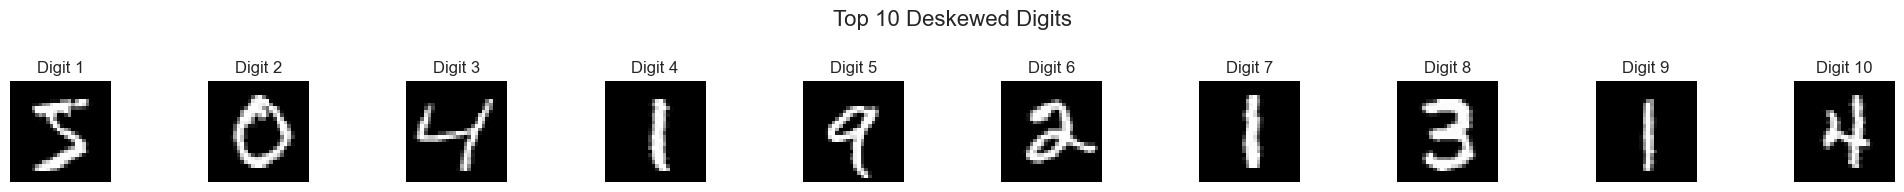

In [8]:

n_samples_to_show = 10

# Assuming deskewed_digits is already defined and contains the deskewed images
# For simplicity, we'll take the first 10 digits
selected_digits = deskewed_digits[:n_samples_to_show]

plt.figure(figsize=(n_samples_to_show * 2, 2))
for i in range(n_samples_to_show):
    plt.subplot(1, n_samples_to_show, i + 1)
    plt.imshow(selected_digits[i], cmap='gray')
    plt.title(f'Digit {i+1}')
    plt.axis('off')

plt.suptitle('Top 10 Deskewed Digits', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# ------------------------------------------------------------
# [Cell 8] Save processed dataset into a single npz file
#   - This file will be used by 02_train_classical_ml.ipynb
# ------------------------------------------------------------

np.savez_compressed(
    OUT_NPZ,
    X_train=X_train_pca.astype(np.float32), # store train X as PCA
    X_val=X_val_pca.astype(np.float32), # store val X as PCA
    X_test=X_test_pca.astype(np.float32), # store test X as PCA
    y_train=y_train.astype(np.int64), # Add y_train
    y_val=y_val.astype(np.int64),     # Add y_val
    y_test=y_test.astype(np.int64),   # Add y_test

    X_train_raw=X_train_raw.astype(np.float32),
    X_val_raw=X_val_raw.astype(np.float32),
    X_test_raw=X_test_raw.astype(np.float32),
    # If you also need y_raw versions, add them here
)

print(f"[DONE] Saved processed Colored MNIST to {OUT_NPZ}")

[DONE] Saved processed Colored MNIST to c:\src\colored-mnist-classification\data\processed\deskewed_pca_mnist.npz
